# pull_telemetry_example.ipynb
This notebook provides a tutorial for use of the Python `microSWIFTtelemetry` package.

Jake Davis (davisjr@uw.edu)\
Last updated: Nov 6, 2022

## Contents

`microSWIFTtelemetry` contains a collection of python functions for accessing data from the UW-APL SWIFT server:

http://swiftserver.apl.washington.edu/ (base URL)\
http://faculty.washington.edu/jmt3rd/SWIFTdata/DynamicDataLinks.html (HTML page)

The primary functions are contained in `pull_telemetry.py`. These include:

`pull_telemetry_as_var()` -- return request as a variable in memory\
`pull_telemetry_as_zip()` -- return request as a .zip file\
`pull_telemetry_as_json()` -- return request as JSON-formatted text\
`pull_telemetry_as_kml()` -- return a .kml file of GPS positions

Please see the doc strings in `pull_telemetry.py` for a full description of these functions and their arguments.

This file also contains the helper function `create_request()` which is not intended for use outside of the primary functions above.  The modules `read_SBD.py` and `compile_SBD.py` contain additional helper functions for unpacking data (in the form of Short Burst Data files) from the server.

## Installation:
The latest release of `microSWIFTtelemetry` can be installed from PyPI: 

``` bash
$ pip install microSWIFTtelemetry
```

## Examples:

### Specifying microSWIFT ID and date range:

All of the primary telemetry functions use the microSWIFT ID and a date range as base arguments. 

The ID should be defined as a string corresponding to the 3-digit microSWIFT name (including leading zeros). e.g. microSWIFT019:

In [7]:
buoyID = '019'

To query a list of IDs, current best practice us to create a list of IDs and loop over it. This makes it easier to handle the output, particularly when it is returned as a variable in memory.

In [8]:
buoyIDs = ['019', '034', '057', '061']

The date range over which to query the server is defined using datetime objects:

In [9]:
from datetime import datetime # import the datetime class from the datetime module

start = datetime(2022,9,26,0,0,0)
end = datetime(2022,9,29,0,0,0)

If the `end` date is left empty for any of the pull telemetry functions, it will default to `datetime.utcnow()`.

### Pull telemetry as a variable for a single buoy

The following examples demonstrate how to query the SWIFT server for microSWIFT data over a date range and 
return it as Python variable using `pull_telemetry_as_var()`. NOTE: the `.zip` file of short burst data (SBD) messages returned by the server is *handled in memory* and therefore is not saved to the local machine as a file. Use `pull_telemetry_as_zip()` for this purpose. 

If no data exists over the specified date range, an empty variable will be returned.

As a Python `dict`:

In [10]:
from microSWIFTtelemetry import pull_telemetry_as_var

SWIFT_dict = pull_telemetry_as_var(buoyID = buoyID, startDate = start, endDate= end, varType = 'dict')

print(SWIFT_dict.keys()) # e.g. SWIFT_dict['datetime']
print(len(SWIFT_dict['datetime'])) # print number of entries

dict_keys(['vMean', 'f', 'zMean', 'volt', 'datetime', 'Dp', 'E', 'check', 'b1', 'Tp', 'b2', 'Hs', 'a2', 'salinity', 'lat', 'sensorType', 'lon', 'temp', 'a1', 'uMean'])
98


Leaving the `endDate` argument empty will return any available data from `startTime` to the present time in UTC (though data may not be available up to the present time)

In [11]:
from microSWIFTtelemetry import pull_telemetry_as_var

SWIFT_dict = pull_telemetry_as_var(buoyID = buoyID, startDate = start, varType = 'dict')

print(SWIFT_dict.keys()) # e.g. SWIFT_dict['datetime']
print(len(SWIFT_dict['datetime'])) # print number of entries

dict_keys(['vMean', 'f', 'zMean', 'volt', 'datetime', 'Dp', 'E', 'check', 'b1', 'Tp', 'b2', 'Hs', 'a2', 'salinity', 'lat', 'sensorType', 'lon', 'temp', 'a1', 'uMean'])
217


As a `pandas.DataFrame`:

In [12]:
from microSWIFTtelemetry import pull_telemetry_as_var

SWIFT_df = pull_telemetry_as_var(buoyID = buoyID, startDate = start, endDate= end, varType = 'pandas')
print(SWIFT_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98 entries, 2022-09-26 16:40:32+00:00 to 2022-09-28 23:40:48+00:00
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          98 non-null     float64
 1   Tp          98 non-null     float64
 2   Dp          98 non-null     float64
 3   E           98 non-null     object 
 4   f           98 non-null     object 
 5   a1          98 non-null     object 
 6   b1          98 non-null     object 
 7   a2          98 non-null     object 
 8   b2          98 non-null     object 
 9   check       98 non-null     object 
 10  uMean       0 non-null      object 
 11  vMean       0 non-null      object 
 12  zMean       0 non-null      object 
 13  lat         98 non-null     float64
 14  lon         98 non-null     float64
 15  temp        98 non-null     float64
 16  salinity    98 non-null     float64
 17  volt        98 non-null     float64
 18  sensorType  98 non-nul

The microSWIFT DataFrame will have a `pandas.DatetimeIndex` that can be sliced using datetimes.

In [13]:
from datetime import datetime, timezone

t1 = datetime(2022,9,28, tzinfo=timezone.utc)
t2 = datetime(2022,9,29, tzinfo=timezone.utc)

print(SWIFT_df[t1:t2].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 2022-09-28 01:42:24+00:00 to 2022-09-28 23:40:48+00:00
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Hs          38 non-null     float64
 1   Tp          38 non-null     float64
 2   Dp          38 non-null     float64
 3   E           38 non-null     object 
 4   f           38 non-null     object 
 5   a1          38 non-null     object 
 6   b1          38 non-null     object 
 7   a2          38 non-null     object 
 8   b2          38 non-null     object 
 9   check       38 non-null     object 
 10  uMean       0 non-null      object 
 11  vMean       0 non-null      object 
 12  zMean       0 non-null      object 
 13  lat         38 non-null     float64
 14  lon         38 non-null     float64
 15  temp        38 non-null     float64
 16  salinity    38 non-null     float64
 17  volt        38 non-null     float64
 18  sensorType  38 non-nul

In the future, other variable types (e.g. `xarray.Dataset`) will be supported.

### Pull telemetry as a variable for multiple buoys

For multiple microSWIFTs, run `pull_telemetry_as_var()` in a loop and store the individual variables in an iterable. For example, query the server for the microSWIFTs in `buoyIDs` (defined above) and store the output as individual Pandas DataFrames in a dictionary:

In [14]:
from microSWIFTtelemetry import pull_telemetry_as_var

microSWIFTs = dict() # initialize a dict to store individual DataFrames

for buoyID in buoyIDs:
    microSWIFTs[buoyID] = pull_telemetry_as_var(buoyID = buoyID, startDate = start, endDate= end, varType = 'pandas')

print(microSWIFTs.keys())

dict_keys(['019', '034', '057', '061'])


The key-pair values will contain a DataFrame for each microSWIFT:

In [15]:
microSWIFTs['019'].head()

,Hs,Tp,Dp,E,f,a1,b1,a2,b2,check,uMean,vMean,zMean,lat,lon,temp,salinity,volt,sensorType
datetime,,,,,,,,,,,,,,,,,,,
2022-09-26 16:40:32+00:00,999.000000,999.000000,999.000,"[999.0, 999.0, 999.0, 999.0, 999.0, 999.0, 999...","[999.0, 999.0, 999.0, 999.0, 999.0, 999.0, 999...","[0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, ...","[0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, ...","[0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, ...","[0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, ...","[25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25....",None,None,None,999.000000,999.000000,0.0,0.0,0.0,52
2022-09-26 18:42:08+00:00,2.111328,4.097656,350.500,"[0.0362548828125, 0.47607421875, 1.4423828125,...","[0.009765625, 0.021484375, 0.033203125, 0.0449...","[0.03, -0.01, 0.01, 0.2, 0.18, 0.13, 0.11, 0.2...","[0.09, 0.1, 0.02, 0.18, 0.05, 0.03, 0.0, 0.03,...","[-0.43, 0.14, -0.11, -0.1, -0.33, -0.04, -0.2,...","[-0.24, -0.32, -0.04, 0.04, -0.12, -0.13, 0.17...","[3.4, 22.9, 24.3, 25.5, 25.5, 25.5, 21.4, 16.5...",None,None,None,26.196615,-83.811127,0.0,0.0,0.0,52
2022-09-26 18:42:08+00:00,0.672363,4.097656,13.125,"[0.0, 0.0, 0.0, 0.0, 0.237060546875, 0.3435058...","[0.009765625, 0.021484375, 0.033203125, 0.0449...","[-0.05, 0.18, -0.1, 0.05, 0.03, 0.02, -0.03, -...","[-0.03, -0.06, -0.01, -0.17, 0.07, -0.03, -0.0...","[0.28, 0.06, -0.14, -0.1, -0.31, -0.03, -0.19,...","[-0.11, -0.24, 0.02, 0.02, -0.13, -0.15, 0.19,...","[0.0, 0.1, 0.1, 0.1, 0.2, 0.1, 0.2, 0.2, 0.1, ...",None,None,None,26.196615,-83.811127,0.0,0.0,1.0,52
2022-09-26 19:41:52+00:00,0.796387,2.679688,91.625,"[0.0, 0.0, 0.0, 0.0, 0.411865234375, 0.5893554...","[0.009765625, 0.021484375, 0.033203125, 0.0449...","[-0.17, -0.06, -0.01, 0.01, -0.01, -0.01, -0.0...","[-0.1, -0.05, -0.07, 0.08, -0.08, -0.21, -0.12...","[0.29, 0.03, 0.13, 0.02, 0.07, -0.06, -0.01, -...","[0.04, -0.17, 0.01, -0.13, -0.17, -0.16, -0.33...","[0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.1, ...",None,None,None,26.194782,-83.815460,0.0,0.0,1.0,52
2022-09-26 19:41:52+00:00,2.824219,2.679688,78.750,"[0.07769775390625, 0.53564453125, 2.822265625,...","[0.009765625, 0.021484375, 0.033203125, 0.0449...","[0.09, 0.05, 0.1, 0.1, 0.03, 0.21, 0.14, 0.24,...","[-0.04, -0.2, -0.07, -0.06, 0.0, -0.07, -0.15,...","[-0.05, -0.06, 0.17, 0.03, 0.07, -0.06, -0.03,...","[-0.06, -0.2, 0.08, -0.15, -0.2, -0.16, -0.36,...","[4.9, 12.8, 25.5, 25.5, 25.5, 25.5, 25.5, 25.0...",None,None,None,26.194782,-83.815460,0.0,0.0,0.0,52


### Pull telemetry as a zip file:

Query the SWIFT server for microSWIFT data over a specified date range and download a `.zip` file of individual short burst data (SBD) messages.

In [16]:
from microSWIFTtelemetry import pull_telemetry_as_zip

pull_telemetry_as_zip(buoyID = buoyID, startDate = start, endDate= end)

The `.zip` file will be saved in your current directory with the microSWIFTs name, e.g. `microSWIFT019.zip`. If data exists, it the unzipped folder will contain the `.sbd` files.

For multiple microSWIFTs:

In [17]:
from microSWIFTtelemetry import pull_telemetry_as_zip

for buoyID in buoyIDs:
    pull_telemetry_as_zip(buoyID = buoyID, startDate = start, endDate= end)

### Pull telemetry as JSON text:

Query the SWIFT server and return a variable containing JSON-formatted text.

In [18]:
from microSWIFTtelemetry import pull_telemetry_as_json

SWIFT_json = pull_telemetry_as_json(buoyID = '019', startDate = start, endDate= end)
print(SWIFT_json)

{'error_msg': [], 'success': True, 'buoys': [{'data': [{'wind_speed': 0, 'timestamp': '2022-09-26T18:42:20Z', 'lon': -83.8111267089844, 'wave_height': 2.111328125, 'voltage': 0.0, 'lat': 26.1966152191162}, {'wind_speed': 0, 'timestamp': '2022-09-26T18:45:53Z', 'lon': -83.8111267089844, 'wave_height': 0.67236328125, 'voltage': 1.0, 'lat': 26.1966152191162}, {'wind_speed': 0, 'timestamp': '2022-09-26T18:46:37Z', 'lon': 999.0, 'wave_height': 999.0, 'voltage': 0.0, 'lat': 999.0}, {'wind_speed': 0, 'timestamp': '2022-09-26T19:42:48Z', 'lon': -83.8154602050781, 'wave_height': 2.82421875, 'voltage': 0.0, 'lat': 26.1947822570801}, {'wind_speed': 0, 'timestamp': '2022-09-26T19:57:24Z', 'lon': -83.8154602050781, 'wave_height': 0.79638671875, 'voltage': 1.0, 'lat': 26.1947822570801}, {'wind_speed': 0, 'timestamp': '2022-09-26T20:42:36Z', 'lon': -83.8204193115234, 'wave_height': 2.53125, 'voltage': 0.0, 'lat': 26.1954097747803}, {'wind_speed': 0, 'timestamp': '2022-09-26T20:43:08Z', 'lon': -83.820

This variable can then be handled using the `json` package:

In [19]:
import json

with open('SWIFT.json', 'w') as f:
    json.dump(SWIFT_json, f)

### Pull telemetry as a KML file

Query the SWIFT server for microSWIFT data over a specified date range and download a `.kml` file containing the buoy's GPS coordinates.  

In [20]:
from microSWIFTtelemetry import pull_telemetry_as_kml

pull_telemetry_as_kml(buoyID = buoyID, startDate = start, endDate= end)

The `.kml` file will be saved in your current directory with the microSWIFTs name and the corresponding date range in ISO 8601 format (in UTC), e.g. `microSWIFT019_{y-m-dTH:M:S}_to_{y-m-dTH:M:S}-.kml`.

For multiple microSWIFTs:

In [21]:
from microSWIFTtelemetry import pull_telemetry_as_kml
for buoyID in buoyIDs:
    pull_telemetry_as_kml(buoyID = buoyID, startDate = start, endDate= end)

### Complete examples:

Pull telemetry from microSWIFT057 during Hurricane Ian and store it in memory as a Python dictionary. Extract the time and significant wave height as variables. Since the microSWIFTs were configured to report two wave estimates during this deployment, IMU-based (volt == 0) and GPS-based (volt == 1), filter for the GPS-based estimates and plot the result.

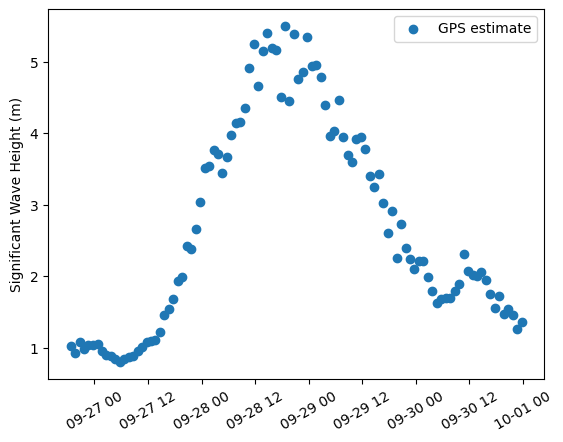

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from microSWIFTtelemetry import pull_telemetry_as_var
from datetime import datetime 

buoyID = '057'
start = datetime(2022,9,26,0,0,0)
end = datetime(2022,10,1,0,0,0)

SWIFT_dict = pull_telemetry_as_var(buoyID = buoyID, startDate = start, endDate= end, varType = 'dict')

t = np.array(SWIFT_dict['datetime'])
Hs = np.array(SWIFT_dict['Hs'])
voltFlag = np.array(SWIFT_dict['volt'])


fig,ax = plt.subplots(1,1)
ax.scatter(t[voltFlag == 1], Hs[voltFlag == 1], label = 'GPS estimate')
ax.set_ylabel('Significant Wave Height (m)')
plt.xticks(rotation=30)
ax.legend()

Do the same as above, but using a more versatile Pandas DataFrame. 

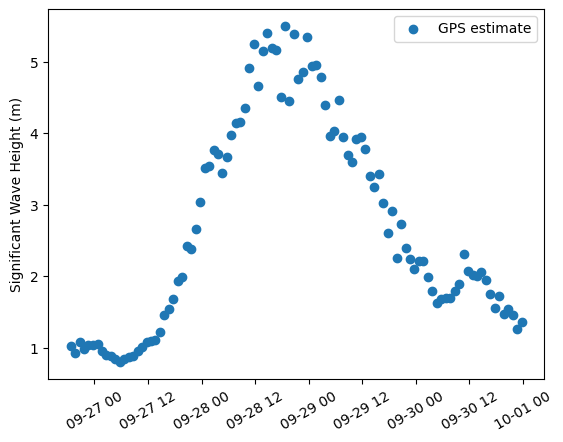

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from microSWIFTtelemetry import pull_telemetry_as_var
from datetime import datetime 

buoyID = '057'
start = datetime(2022,9,26,0,0,0)
end = datetime(2022,10,1,0,0,0)

SWIFT_df = pull_telemetry_as_var(buoyID = buoyID, startDate = start, endDate= end, varType = 'pandas')

SWIFT_GPS = SWIFT_df[SWIFT_df['volt'] == 1]

fig,ax = plt.subplots(1,1)
ax.scatter(SWIFT_GPS.index, SWIFT_GPS['Hs'], label = 'GPS estimate')
ax.set_ylabel('Significant Wave Height (m)')
plt.xticks(rotation=30)
ax.legend()